In [1]:
import os
import numpy as np
import pandas as pd
import torch
import os.path as osp
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle
import pycocotools.mask as mutils

IMG_DIR = '/mnt/chicm/data/open-images/train/imgs'
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'
MASK_DIR = '/mnt/chicm/data/open-images/masks/train'

In [6]:
#with open('../work_dirs/htc_level1_275/preds_0913am_all_lb4304.pkl', 'rb') as f:
with open('../preds_0913am_all_lb4304.pkl', 'rb') as f:
    preds1 = pickle.load(f)

In [2]:
#with open('../preds_0902_3_50_all_lb04195.pkl', 'rb') as f:
with open('../work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0902_3_50_all_lb04195.pkl', 'rb') as f:
    preds2 = pickle.load(f)

In [7]:
def get_top_classes(start_index, end_index):
    df = pd.read_csv('top_classes_level1.csv')
    c = df['class'].values[start_index:end_index]
    #print(df.head())
    stoi = { c[i]: i for i in range(len(c)) }
    return c, stoi

classes, stoi = get_top_classes(0, 275)

In [8]:
classes[:2]

array(['/m/05r655', '/m/083wq'], dtype=object)

In [9]:
def get_dets(preds, idx):
    box_pred, mask_pred = preds[idx]
    #masks, labels, confs = [], [], []
    dets = []
    for i in range(len(classes)):
        for encoded_mask, bbox in zip(mask_pred[i], box_pred[i]):
            if True:
                mask = mutils.decode(encoded_mask)
                #masks.append(mask)
                #labels.append(classes[i])
                #confs.append(bbox[4])
                dets.append([mask, classes[i], bbox[4]])
                
    return dets

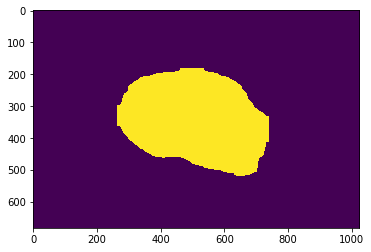

In [10]:
tmp_det1 = get_dets(preds1, 0)
plt.imshow(tmp_det1[0][0])

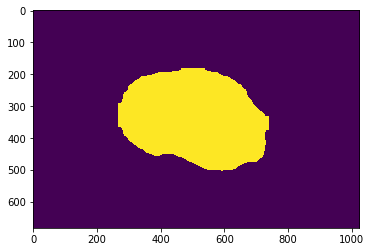

In [11]:
tmp_det2 = get_dets(preds2, 0)
plt.imshow(tmp_det2[0][0])

In [12]:
def general_ensemble(dets, iou_thresh = 0.5, weights=None):
    assert(type(iou_thresh) == float)
    
    ndets = len(dets)
    
    if weights is None:
        w = 1/float(ndets)
        weights = [w]*ndets
    else:
        assert(len(weights) == ndets)
        
        s = sum(weights)
        for i in range(0, len(weights)):
            weights[i] /= s

    out = list()
    used = list()
    
    for idet in range(0,ndets):
        det = dets[idet]
        for box in det:
            if box[2] in used:
                continue
                
            used.append(box[2])
            # Search the other detectors for overlapping box of same class
            found = []
            for iodet in range(0, ndets):
                odet = dets[iodet]
                
                if iodet == idet:
                    continue
                
                bestbox = None
                bestiou = iou_thresh
                for obox in odet:
                    if not obox[2] in used:
                        # Not already used
                        if box[1] == obox[1]:
                            # Same class
                            iou = computeIOU(box[0], obox[0])
                            if iou > bestiou:
                                bestiou = iou
                                bestbox = obox
                                
                if not bestbox is None:
                    w = weights[iodet]
                    found.append((bestbox,w))
                    used.append(bestbox[2])
                            
            # Now we've gone through all other detectors
            if len(found) == 0:
                new_box = list(box)
                new_box[2] /= ndets
                out.append(new_box)
            else:
                allboxes = [(box, weights[idet])]
                allboxes.extend(found)
                
                conf = 0.0
                
                wsum = 0.0
                masks = []
                for bb in allboxes:
                    w = bb[1]
                    wsum += w
                    b = bb[0]
                    conf += w*b[2]
                    masks.append(b[0].astype(np.float32))
                
                new_mask = (np.mean(masks, 0) > 0.51).astype(np.uint8)
                new_box = [new_mask, box[1], conf]
                out.append(new_box)
    return out


def computeIOU(mask1, mask2):
    
    intersect_area = ((mask1 * mask2) > 0).sum()
    
    iou = intersect_area / ((mask1 + mask2) > 0).sum()
    return iou


In [13]:
len(preds1)

99999

In [1]:
'''
import time

bg = time.time()
ens_dets = []
for i in tqdm(range(len(preds1[:100]))):
    det1 = get_dets(preds1, i)
    det2 = get_dets(preds2, i)
    #ens_dets.append(general_ensemble([det1, det2], weights=[0.6, 0.4]))
    ens_det = general_ensemble([det1, det2], weights=[0.6, 0.4])
    ens_dets.append(sorted(ens_det, key=lambda x: x[2], reverse=True)[:50])

print('total time:', (time.time()-bg)/60)
'''

"\nimport time\n\nbg = time.time()\nens_dets = []\nfor i in tqdm(range(len(preds1[:100]))):\n    det1 = get_dets(preds1, i)\n    det2 = get_dets(preds2, i)\n    #ens_dets.append(general_ensemble([det1, det2], weights=[0.6, 0.4]))\n    ens_det = general_ensemble([det1, det2], weights=[0.6, 0.4])\n    ens_dets.append(sorted(ens_det, key=lambda x: x[2], reverse=True)[:50])\n\nprint('total time:', (time.time()-bg)/60)\n"

In [ ]:
encode_binary_mask(det[0].astype(np.bool))

In [29]:
def get_ens_det(idx):
    det1 = get_dets(preds1, idx)
    det2 = get_dets(preds2, idx)
    ens_det = general_ensemble([det1, det2], weights=[0.6, 0.4])
    ens_det = [[encode_binary_mask(x[0].astype(np.bool)), x[1], x[2]] for x in ens_det]
    del det1, det2
    return sorted(ens_det, key=lambda x: x[2], reverse=True)[:50]

In [33]:
from multiprocessing import Pool
import time

bg = time.time()

with Pool(24) as p:
    num_imgs = len(preds1[:1000])
    ens_dets = list(tqdm(iterable=p.map(get_ens_det, list(range(num_imgs))), total=num_imgs))
    #ens_dets = p.map(get_ens_det, range(num_imgs))
    
print('total time:', (time.time()-bg)/60) 

/mnt/chicm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
/mnt/chicm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
/mnt/chicm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
/mnt/chicm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
/mnt/chicm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
/mnt/chicm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
/mnt/chicm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
/mnt/chicm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

total time: 1.2973966201146443


In [35]:
del ens_dets

NameError: name 'ens_dets' is not defined

In [26]:
plt.imshow(ens_dets[0][0][0])

NameError: name 'ens_dets' is not defined

# create submission

In [ ]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            raise AssertionError('imghead len != 24')
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                raise AssertionError('png check failed')
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                raise
        else:
            print(fname, imghdr.what(fname))
            #raise AssertionError('file format not supported')
            img = cv2.imread(fname)
            print(img.shape)
            height, width, _ = img.shape

        return width, height


In [27]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)
    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode('utf-8')
    

In [ ]:
def get_fn(img_id):
    return TEST_IMG_DIR + '/' + img_id + '.jpg'

In [ ]:
DATA_DIR = '/mnt/chicm/data/open-images/segmentation'
df_test = pd.read_csv(osp.join(DATA_DIR, 'sample_empty_submission.csv'))

In [ ]:
df_test.ImageWidth = df_test.ImageID.map(lambda x: get_image_size(get_fn(x))[0])
df_test.ImageHeight = df_test.ImageID.map(lambda x: get_image_size(get_fn(x))[1])
df_test['img_index'] = df_test.index

df_test.head()

In [ ]:
def get_pred_str(idx):
    #masks, labels, confs = get_mask(idx)
    res = []
    #for mask, label, conf in zip(masks, labels, confs):
    for det in ens_dets[idx]:
        res.append(det[1])
        res.append('{:.7f}'.format(det[2]))
        #res.append(encode_binary_mask(det[0].astype(np.bool)))
        res.append(det[0])
    
    return ' '.join(res)

In [ ]:
def set_pred_str(df):
    df['PredictionString'] = df.img_index.map(lambda x: get_pred_str(x))
    return df

In [ ]:
from multiprocessing import Pool

def parallel_apply(df, func, n_cores=24):
    #ncores = 24
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
df_test = parallel_apply(df_test, set_pred_str)

In [ ]:
df_test = df_test.drop(columns=['img_index'], axis=1)
df_test.head()

In [ ]:
df_test.to_csv('sub_ens_275_0913_top50.csv', index=False)

In [ ]:
!kaggle competitions submit -c open-images-2019-instance-segmentation -f sub_ens_275_0913_top50.csv -m "0904 night submit"